# Sea Ice Extent Timeseries
## **ECCO**

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.31b2fee6c187448cbe30012cb8b49b82 Dashboard: /services/dask-gateway/clusters/staging.31b2fee6c187448cbe30012cb8b49b82/status,Cluster Workers: 30 Cores: 60 Memory: 240.00 GiB


In [18]:
client.close()
cluster.close()

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from fastjmd95 import jmd95numba

In [3]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["ECCOv4r3"].to_dask()

In [4]:
ds_ll = faces_dataset_to_latlon(ds)

In [5]:
# a trick to make things work a bit faster
coords_before_drop = ds_ll.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds_before_drop = ds_ll.reset_coords(drop=True).roll(i=50, i_g=50)

<ipython-input-5-db7afb74131b>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords_before_drop = ds_ll.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
<ipython-input-5-db7afb74131b>:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_before_drop = ds_ll.reset_coords(drop=True).roll(i=50, i_g=50)


In [6]:
coords = coords_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])
ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [7]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [8]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [9]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

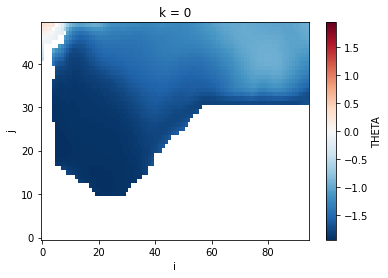

In [12]:
#testing to see if correctly sliced desired region
sst_mean = ds.THETA.sel(**lat_range_noface, **lon_range_noface).sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0].isel(**lat_range_noface, **lon_range_noface)>0)
sst_mean.where(surface_mask).plot()

In [14]:
ds.time

<xarray.DataArray 'time' (time: 288)>
array(['1992-01-15T00:00:00.000000000', '1992-02-13T00:00:00.000000000',
       '1992-03-15T00:00:00.000000000', ..., '2015-10-15T00:00:00.000000000',
       '2015-11-14T00:00:00.000000000', '2015-12-14T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [15]:
time = ds.time

In [16]:
time.to_netcdf('time_pangeo')

## Saving Data

In [2]:
ice = xr.open_dataarray('sea-ice-ecco')

In [7]:
ice = ice.to_dataset()

In [4]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [8]:
#uploading seaice 
gcsmap_seaice = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/seaice.zarr')
ice.to_zarr(gcsmap_seaice, mode='w')